In [21]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import MinMax
import rasterio as rio
from scipy.spatial.distance import cdist


data_dir = Path('../data')

In [22]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = bandwidth * 2

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': 'float64',
        'width': len(x),
        'height': len(y),
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def get_S(
        data,
        bandwidth,
        cell_size,
        kernel_function,
):
    if data.empty:
        return None

    density_total, _ = kernel_density_surface(
        data,
        group='total',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )
    density_orthodox, _ = kernel_density_surface(
        data,
        group='orthodox',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )

    density = pd.DataFrame({
            'orthodox': density_orthodox.flatten(),
            'total': density_total.flatten(),
         })
    S = MinMax(density, 'orthodox', 'total')

    return S


In [23]:
def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:

    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)

    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)

    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)

    return pop_frame

In [24]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()


In [25]:
def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

           100       150       200       250       300       400       500
1880  0.559166  0.496829  0.446714  0.407897  0.377213  0.332894  0.297595
1885  0.606040  0.547871  0.505009  0.473676  0.449546  0.406159  0.363670
1890  0.534004  0.452861  0.398875  0.363904  0.340725  0.308044  0.280256
1895  0.533366  0.473795  0.429488  0.391491  0.359740  0.315887  0.282440
1900  0.515263  0.429829  0.379056  0.348062  0.326527  0.294227  0.269373
1905  0.524359  0.431515  0.375474  0.334753  0.305739  0.268475  0.243571
1910  0.562807  0.456129  0.390493  0.346308  0.309783  0.254872  0.216320
1915  0.576260  0.514560  0.480364  0.453987  0.431820  0.398362  0.382732
1920  0.511375  0.390346  0.320462  0.272872  0.237793  0.192468  0.171250


<AxesSubplot:>

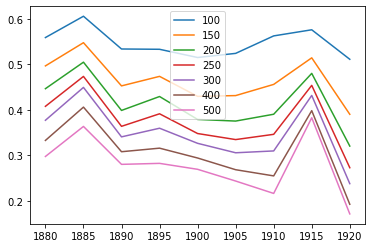

In [26]:
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}

location_data = gpd.read_file(data_dir / 'raw' / 'plots_1878.shp').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])

results = {}
bws = 100, 150, 200, 250, 300, 400, 500

for year in range(1880, 1921, 5):
    s_ = []

    for bw in bws:
        population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)

        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)

        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)

        S = get_S(
            data=page_location_data,
            bandwidth=bw,
            cell_size=25,
            kernel_function=quartic_kernel,
        )

        s_.append(S.statistic)

    results[year] = s_

results = pd.DataFrame.from_dict(
    results,
    orient='index',
    columns=bws,
)
print(results)
results.plot()

In [27]:
for year in range(1880, 1921, 5):
    population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)

    print(population_data.loc[:, ['district', 'lutheran', 'orthodox']].groupby('district').sum())


                      lutheran  orthodox
district                                
Anina                      448        33
Havi                       119         0
Hiekka                     230        28
Kolikkoinmäki              124         5
Likolampi                  107         1
P_Annan_kruunu             100        17
Pantsarlahti               992         9
Papula                     194         3
Paulovski                  448        22
Pietarin_esikaupunki      2384       288
Pikiruukki                  84         3
Repola                     283        29
Salakkalahti               382         4
Saunalahti                 110        13
Saunalahti_mlk              63         8
Sorvali                    203        32
Valli                     2251       244
Viipurin_esikaupunki       654        99
Viipurin_pitäjä             84         5
                      lutheran  orthodox
district                                
Anina                      660        26
Havi            